# Baseline

> This module groups the methods related to the baseline estimation.

In [ ]:
#| default_exp baseline

In [ ]:
#| export
#| hide
import inspect
import xarray as xr

In [ ]:
#| hide
import pandas as pd
import matplotlib.pyplot as plt
from raincell import open_cml_sample
from raincell.sample import get_cml_sample_fp
from raincell import wetdry

In [ ]:
cml, wet = open_cml_sample(), open_cml_sample("wetdry")

## Last dry step as baseline

We will implement the simplest possible model, which consists of assuming that the baseline is constant and equal to the last step classified as dry. This algorithm only requires past time steps, which makes it very suitable for real-time rainfall estimation. In addition, it is very easy to compute, which makes it suitable for low-resource computation. So let's say we have the following time series for a sublink:

In [ ]:
#| echo:false
ex_att = [59, 60, 90, 75, 59, 58, 59, 80]
ex_att

[59, 60, 90, 75, 59, 58, 59, 80]


And lets assume that our wet/dry classification model classified the data as:

In [ ]:
#| echo:false
ex_wet = ["dry" if v < 70 else "wet" for v in ex_att]
ex_wet

['dry', 'dry', 'wet', 'wet', 'dry', 'dry', 'dry', 'wet']

Then the baseline would be:

In [ ]:
#| echo:false
ex_bl = []
for val, wd in zip(ex_att, ex_wet): ex_bl.append(ex_bl[-1] if wd == "wet" else val)
pd.DataFrame([ex_att, ex_wet, ex_bl], index=["Attenuation", "Wet/Dry", "Baseline"]).T

,Attenuation,Wet/Dry,Baseline
0,59,dry,59
1,60,dry,60
2,90,wet,60
3,75,wet,60
4,59,dry,59
5,58,dry,58
6,59,dry,59
7,80,wet,59


In [ ]:
#| hide
link = cml.isel(cml_id=0).dropna(dim="sublink_id", how="all")
link

<xarray.Dataset> Size: 308kB
Dimensions:      (sublink_id: 2, time: 2964)
Coordinates: (10)
Data variables:
    rsl_avg      (sublink_id, time) float64 47kB -48.0 -48.0 ... -46.4 -46.4
    tsl_avg      (sublink_id, time) float64 47kB 10.0 10.0 10.0 ... 10.0 10.0
    rsl_min      (sublink_id, time) float64 47kB -48.8 -48.3 ... -46.5 -46.7
    tsl_min      (sublink_id, time) float64 47kB 10.0 10.0 10.0 ... 10.0 10.0
    rsl_max      (sublink_id, time) float64 47kB -47.6 -47.8 ... -46.2 -46.2
    tsl_max      (sublink_id, time) float64 47kB 10.0 10.0 10.0 ... 10.0 10.0
Attributes:
    title:                 East side Douala CML links sample data
    file author(s):        Orange Cameroun and IRD Rainsmore Group
    institution:           Orange Cameroun and IRD Rainsmore Group
    date:                  2025-11-07
    source:                Modified Orange Cameroun CML data for example purp...
    naming convention:     COST ACTION OPENSENSE V2
    license restrictions:  CC BY-NC-ND 4.0

In [ ]:
#| hide
att = (link["tsl_max"] - link["rsl_max"]).to_dataset(name="tsl_max-rsl_max")
att["tsl_min-rsl_min"] = link["tsl_min"] - link["rsl_min"]
att


<xarray.Dataset> Size: 119kB
Dimensions:          (sublink_id: 2, time: 2964)
Coordinates: (10)
Data variables:
    tsl_max-rsl_max  (sublink_id, time) float64 47kB 57.6 57.8 ... 56.2 56.2
    tsl_min-rsl_min  (sublink_id, time) float64 47kB 58.8 58.3 ... 56.5 56.7

In [ ]:
#| hide
dry = ~wet
dry_att = att.where(dry)
dry_att

<xarray.Dataset> Size: 12MB
Dimensions:          (sublink_id: 2, time: 2964, cml_id: 126)
Coordinates: (3)
Data variables:
    tsl_max-rsl_max  (sublink_id, time, cml_id) float64 6MB 57.6 57.6 ... 56.2
    tsl_min-rsl_min  (sublink_id, time, cml_id) float64 6MB 58.8 58.8 ... 56.7

In [ ]:
#| hide
baseline = dry_att.ffill(dim="time")
baseline

<xarray.Dataset> Size: 12MB
Dimensions:          (sublink_id: 2, time: 2964, cml_id: 126)
Coordinates: (3)
Data variables:
    tsl_max-rsl_max  (sublink_id, time, cml_id) float64 6MB 57.6 57.6 ... 56.2
    tsl_min-rsl_min  (sublink_id, time, cml_id) float64 6MB 58.8 58.8 ... 56.7

In [ ]:
#| hide
for v in baseline.data_vars:
    attrs = baseline[v].attrs
    attrs["long_name"] = getattr(attrs, "long_name", v) + "_baseline"    
    attrs["method"] = "last_dry_step"

In [ ]:
#| exports
def get_bl_as_last_dry_step(
        att: xr.Dataset|xr.DataArray, # ds containing the raw attenuation variables
        wet: xr.DataArray # da containing wet events as booleans
        ) -> xr.Dataset|xr.DataArray: # ds containing the baseline of all the attenuation variables in the input
    """Create a baseline based on the last dry step before the each wet event."""
    def updated_attrs(da, method):
        return {"long_name": getattr(da.attrs, "long_name", da.name) + "_baseline", "method": method}
    baseline = att.where(~wet).ffill(dim="time")
    fname = inspect.currentframe().f_code.co_name
    if isinstance(att, xr.DataArray):
        baseline.attrs = {**baseline.attrs, **updated_attrs(baseline, fname)}
    else:
        for v in baseline.data_vars:
            baseline[v].attrs = {**baseline[v].attrs, **updated_attrs(baseline[v], fname)}
    return baseline

In [ ]:
#| echo:false
att = (cml["tsl_max"] - cml["rsl_max"]).to_dataset(name="tsl_max-rsl_max")
att["tsl_min-rsl_min"] = cml["tsl_min"] - cml["rsl_min"]
baseline = get_bl_as_last_dry_step(att, wet)
baseline

<xarray.Dataset> Size: 36MB
Dimensions:          (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates: (10)
Data variables:
    tsl_max-rsl_max  (cml_id, sublink_id, time) float64 18MB 57.6 57.8 ... nan
    tsl_min-rsl_min  (cml_id, sublink_id, time) float64 18MB 58.8 58.3 ... nan

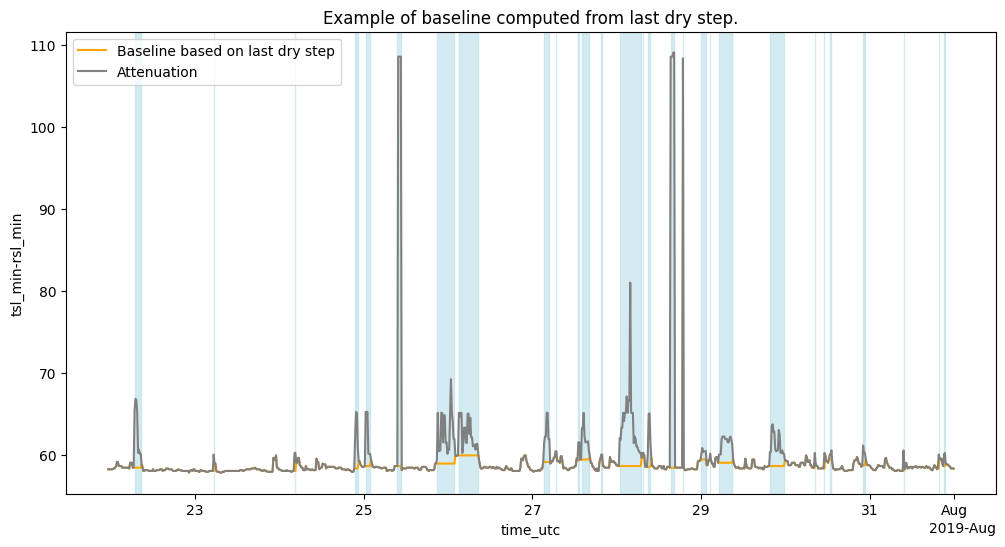

In [ ]:
#| echo:false
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
v="tsl_min-rsl_min"
isel = dict(cml_id=0, sublink_id=0, time=slice(-10*24*4, None))
baseline[v].isel(**isel).plot(ax=ax, label="Baseline based on last dry step", color="orange");
att[v].isel(**isel).plot(ax=ax, label="Attenuation", color="grey")
ax.fill_between(wet.isel(**isel)["time"], 0, 1, where=wet.isel(**isel), color='lightblue', alpha=0.5, transform=ax.get_xaxis_transform())
ax.legend()
ax.set_title(f"Example of baseline computed from last dry step.");

### Sample data generation

To help with development and illustration, we will save the generated wet classification as a sample, as we will need sample data from different processing steps. This sample data is only used for illustration purposes. Additionally, during dry periods, the difference between the minimum, average and maximum signals should be small. For simplicity, we will only save the baseline computed from the average signal.

In [ ]:
var = "baseline"
baseline = get_bl_as_last_dry_step((cml["tsl_avg"] - cml["rsl_avg"]).to_dataset(name=var), wet)
baseline[var].to_netcdf(get_cml_sample_fp("baseline"), encoding={var: {"zlib": True, "complevel": 5}})

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()